# Model development

In [ ]:
import os
import sys

import numpy as np
import seaborn as sns
import shap
import joblib
from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier


/home/rluyck/git/gps-stop-detection/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Add absolute path to the src directory
src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)
    
from preprocessor import read_and_preprocess
from feature_engineering import add_features 
from stop_detector_rb import rule_based_detection
from model_utils import get_feature_columns

In [3]:
# Read and preprocess data
with open("../data/raw/gps_traces.csv", "rb") as f:
    preprocessed_gdf = read_and_preprocess(f.read())

preprocessed_gdf.head()

,trace_number,device_id,geometry,timestamp
0,2,0,POINT (116.59096 40.07196),2009-06-29 07:02:25+00:00
1,2,0,POINT (116.5909 40.07201),2009-06-29 07:02:30+00:00
2,2,0,POINT (116.59088 40.07203),2009-06-29 07:02:35+00:00
3,2,0,POINT (116.59092 40.072),2009-06-29 07:02:40+00:00
4,2,0,POINT (116.59096 40.07198),2009-06-29 07:02:45+00:00


In [4]:
enriched_gdf = add_features(preprocessed_gdf)
enriched_gdf.head()

/home/rluyck/git/gps-stop-detection/src/feature_engineering.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_features_for_trace)


,trace_number,device_id,geometry,timestamp,lat,lon,distance_m,time_diff_s,speed_kmh
0,2,0,POINT (116.59096 40.07196),2009-06-29 07:02:25+00:00,40.071961,116.590957,0.000000,0.0,0.000000
1,2,0,POINT (116.5909 40.07201),2009-06-29 07:02:30+00:00,40.072007,116.590905,6.764954,5.0,4.870767
2,2,0,POINT (116.59088 40.07203),2009-06-29 07:02:35+00:00,40.072027,116.590879,3.138583,5.0,2.259780
3,2,0,POINT (116.59092 40.072),2009-06-29 07:02:40+00:00,40.072004,116.590915,3.994090,5.0,2.875745
4,2,0,POINT (116.59096 40.07198),2009-06-29 07:02:45+00:00,40.071983,116.590961,4.564513,5.0,3.286449


In [5]:
# Label stops with rule-based logic
labeled_df = rule_based_detection(enriched_gdf)
labeled_df.head()

,trace_number,device_id,geometry,timestamp,lat,lon,distance_m,time_diff_s,speed_kmh,stopped
1,2,0,POINT (116.5909 40.07201),2009-06-29 07:02:30+00:00,40.072007,116.590905,6.764954,5.0,4.870767,False
2,2,0,POINT (116.59088 40.07203),2009-06-29 07:02:35+00:00,40.072027,116.590879,3.138583,5.0,2.259780,False
3,2,0,POINT (116.59092 40.072),2009-06-29 07:02:40+00:00,40.072004,116.590915,3.994090,5.0,2.875745,False
4,2,0,POINT (116.59096 40.07198),2009-06-29 07:02:45+00:00,40.071983,116.590961,4.564513,5.0,3.286449,False
5,2,0,POINT (116.59101 40.07196),2009-06-29 07:02:50+00:00,40.071960,116.591012,5.044699,5.0,3.632183,False


### Remove outliers

In [6]:
labeled_df.shape

(5808, 10)

In [7]:
labeled_df["speed_kmh"].describe()

count    5808.000000
mean       18.939399
std        20.111055
min         0.000000
25%         5.371228
50%        12.941570
75%        27.679209
max       392.962870
Name: speed_kmh, dtype: float64

<Axes: title={'center': 'Speed Distribution (km/h)'}, ylabel='Frequency'>

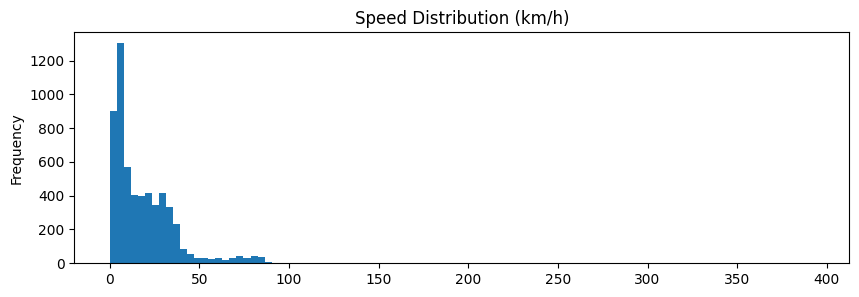

In [8]:
labeled_df["speed_kmh"].plot(kind="hist", bins=100, figsize=(10, 3), title="Speed Distribution (km/h)")

In [9]:
labeled_df = labeled_df[labeled_df['speed_kmh'] < 150]  # Filter out unrealistic speeds

<Axes: title={'center': 'Speed Distribution (km/h)'}, ylabel='Frequency'>

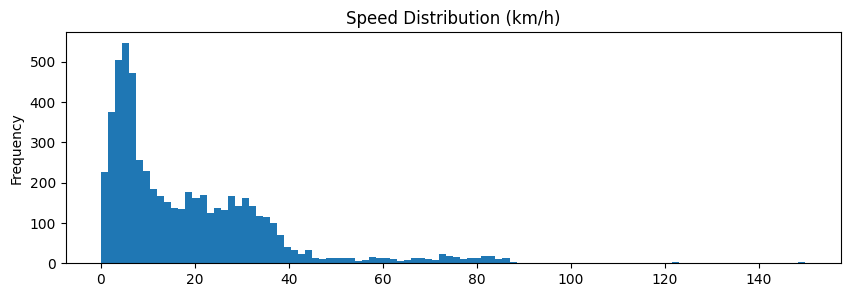

In [10]:
labeled_df["speed_kmh"].plot(kind="hist", bins=100, figsize=(10, 3), title="Speed Distribution (km/h)")

In [11]:
labeled_df["time_diff_s"].describe()

count     5798.000000
mean        10.926354
std        313.543543
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max      19698.000000
Name: time_diff_s, dtype: float64

<Axes: title={'center': 'time_diff (seconds) Distribution'}, ylabel='Frequency'>

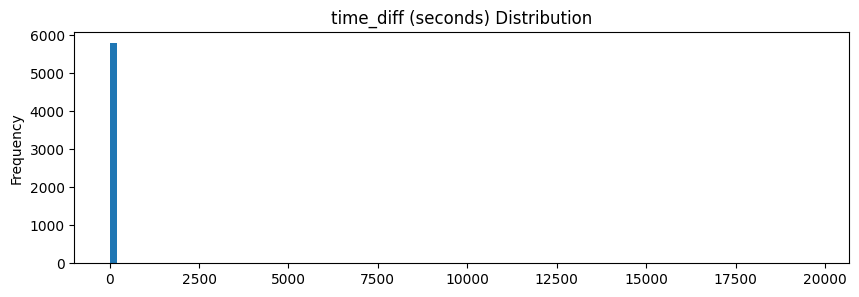

In [12]:
labeled_df["time_diff_s"].plot(kind="hist", bins=100, figsize=(10, 3), title="time_diff (seconds) Distribution")

In [13]:
labeled_df = labeled_df[labeled_df['time_diff_s'] < 10]  # Filter out unrealistic time differences

<Axes: title={'center': 'time_diff (seconds) Distribution'}, ylabel='Frequency'>

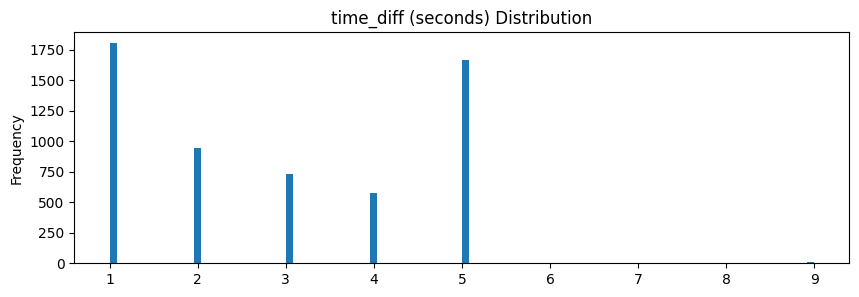

In [14]:
labeled_df["time_diff_s"].plot(kind="hist", bins=100, figsize=(10, 3), title="time_diff (seconds) Distribution")

In [15]:
labeled_df.shape

(5740, 10)

In [16]:
labeled_df.stopped.value_counts()

stopped
False    5629
True      111
Name: count, dtype: int64

### Avoiding data leakage

- We want to keep all GPS points from the same trace together (not part in train, part in test).
- This gives us trace-level generalization and avoids "cheating" by seeing parts of the same trace in both training and evaluation.

In [17]:
unique_traces = labeled_df[['device_id', 'trace_number']].drop_duplicates().reset_index(drop=True)
unique_traces

,device_id,trace_number
0,0,2
1,2,3
2,2,4
3,2,5
4,19,1


### Train (60%), Validation (20%), Test (20%)

1. Split dataset → train / validation / test
2. Train model on training set
3. Tune model using validation set
4. Evaluate it once on the test set

In [18]:
trainval_traces, test_traces = train_test_split(unique_traces, test_size=0.2, random_state=42) # Split 80% for training/validation and 20% for testing
trainval_traces = trainval_traces.reset_index(drop=True)
test_traces = test_traces.reset_index(drop=True)

train_traces, val_traces = train_test_split(trainval_traces, test_size=0.25, random_state=42) # Split 60% for training and 20% for validation
train_traces = train_traces.reset_index(drop=True)
val_traces = val_traces.reset_index(drop=True)


In [19]:
trainval_traces

,device_id,trace_number
0,19,1
1,2,4
2,0,2
3,2,5


In [20]:
train_df = labeled_df.merge(train_traces, on=['device_id', 'trace_number'])  # inner join by default
val_df   = labeled_df.merge(val_traces, on=['device_id', 'trace_number'])
test_df  = labeled_df.merge(test_traces, on=['device_id', 'trace_number'])

In [21]:
train_df.head()

,trace_number,device_id,geometry,timestamp,lat,lon,distance_m,time_diff_s,speed_kmh,stopped
0,2,0,POINT (116.5909 40.07201),2009-06-29 07:02:30+00:00,40.072007,116.590905,6.764954,5.0,4.870767,False
1,2,0,POINT (116.59088 40.07203),2009-06-29 07:02:35+00:00,40.072027,116.590879,3.138583,5.0,2.259780,False
2,2,0,POINT (116.59092 40.072),2009-06-29 07:02:40+00:00,40.072004,116.590915,3.994090,5.0,2.875745,False
3,2,0,POINT (116.59096 40.07198),2009-06-29 07:02:45+00:00,40.071983,116.590961,4.564513,5.0,3.286449,False
4,2,0,POINT (116.59101 40.07196),2009-06-29 07:02:50+00:00,40.071960,116.591012,5.044699,5.0,3.632183,False


In [22]:
feature_cols = get_feature_columns(labeled_df)
feature_cols

X_train = train_df[feature_cols]
y_train = train_df['stopped']

X_val = val_df[feature_cols]
y_val = val_df['stopped']

X_test = test_df[feature_cols]
y_test = test_df['stopped']

In [23]:
X_train.head()

,distance_m,lat,lon
0,6.764954,40.072007,116.590905
1,3.138583,40.072027,116.590879
2,3.994090,40.072004,116.590915
3,4.564513,40.071983,116.590961
4,5.044699,40.071960,116.591012


### Baseline - logistic regression

In [24]:
logreg_clf = make_pipeline(
    StandardScaler(),  # important for logistic regression because sensitive to feature scales 
    LogisticRegression(class_weight='balanced',  # handle class imbalance
                       random_state=42,
                       max_iter=1000)  # this will ensure convergence
)

In [25]:
y_train.value_counts(normalize=True)

stopped
False    0.966729
True     0.033271
Name: proportion, dtype: float64

A high class imbalance

In [26]:
logreg_clf.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [27]:

print("Validation performance:\n")
print(classification_report(y_val, logreg_clf.predict(X_val), zero_division=0))

print("Test performance:\n")
print(classification_report(y_test, logreg_clf.predict(X_test), zero_division=0))


Validation performance:

              precision    recall  f1-score   support

       False       1.00      0.96      0.98      1804
        True       0.20      1.00      0.33        17

    accuracy                           0.96      1821
   macro avg       0.60      0.98      0.65      1821
weighted avg       0.99      0.96      0.97      1821

Test performance:

              precision    recall  f1-score   support

       False       1.00      0.97      0.99      1762
        True       0.33      1.00      0.50        23

    accuracy                           0.97      1785
   macro avg       0.67      0.99      0.74      1785
weighted avg       0.99      0.97      0.98      1785



- De True class (stops) is very rare.
- Logistic regression is a linear model and cannot capture subtle, non-linear boundaries well.

### Random Forest Classifier

- The RandomForestClassifier works by training many decision trees on random subsets of the data and features.
- Each tree votes on the class, and the majority vote decides the final prediction.
- This reduces overfitting and improves generalization compared to a single decision tree.

In [ ]:
# Define a parameter grid for randomized search
param_dist = {
    'n_estimators': randint(100, 400),            # Number of trees in the forest; more trees improve stability but increase training time
    'max_depth': randint(5, 20),                  # Maximum depth of each tree; avoids setting it to None to reduce risk of overfitting
    'min_samples_split': randint(2, 10),          # Minimum number of samples required to split a node; higher values make the model more conservative
    'min_samples_leaf': randint(1, 4),            # Minimum number of samples required at a leaf node; helps reduce overfitting
    'max_features': ['sqrt', 'log2'],             # Number of features to consider when looking for the best split; subsets reduce variance in small datasets
    'class_weight': ['balanced'],                 # Automatically adjusts weights inversely proportional to class frequencies; good for imbalanced classes
}

search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),      # Base model to optimize
    param_distributions=param_dist,               # Parameter grid to sample from
    n_iter=100,                                   # Number of random combinations to try
    scoring='f1_weighted',                        # Evaluation metric that accounts for class imbalance
    cv=5,                                         # 5-fold cross-validation on the training set
    random_state=42,                              # Ensures reproducibility of results
    verbose=1,                                    # Prints progress of the search
    n_jobs=-1                                     # Uses all available cores for parallel processing
)

search.fit(X_train, y_train)                      # Perform the search on training data
best_params = search.best_params_                 # Get the best hyperparameters found

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [29]:
best_params

{'class_weight': 'balanced',
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 187}

In [30]:
rf_clf = RandomForestClassifier(**best_params, random_state=42)
rf_clf.fit(X_train, y_train)

,n_estimators,187
,criterion,'gini'
,max_depth,7
,min_samples_split,4
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
# Evaluate on validation set
print("Validation performance:")
print(classification_report(y_val, rf_clf.predict(X_val)))

Validation performance:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      1804
        True       0.52      1.00      0.68        17

    accuracy                           0.99      1821
   macro avg       0.76      1.00      0.84      1821
weighted avg       1.00      0.99      0.99      1821



In [ ]:
# Evaluate on test set
print("Test performance:")
print(classification_report(y_test, rf_clf.predict(X_test)))

Test performance:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      1762
        True       0.72      1.00      0.84        23

    accuracy                           0.99      1785
   macro avg       0.86      1.00      0.92      1785
weighted avg       1.00      0.99      1.00      1785



In [ ]:
# Save model
model_path = "../models/stop_model_rfc.pkl"
joblib.dump(rf_clf, model_path)

['../models/stop_model_rfc.pkl']

## SHAP values

How SHAP works

- SHAP is based on both the model and the data
- It uses the trained model to see how predictions change when features are included or left out.
- It uses the data to simulate realistic feature combinations.
- In short: SHAP explains how each feature contributes to a prediction, given the model and the data distribution.

### Why we use the validation set (X_val) for SHAP
- We don't use the training set → the model has already seen it; SHAP would reflect memorization.
- We avoid the test set → we keep it untouched for final evaluation.
- The validation set is ideal: it's unseen during training, but okay to use during model development for interpretation like SHAP.

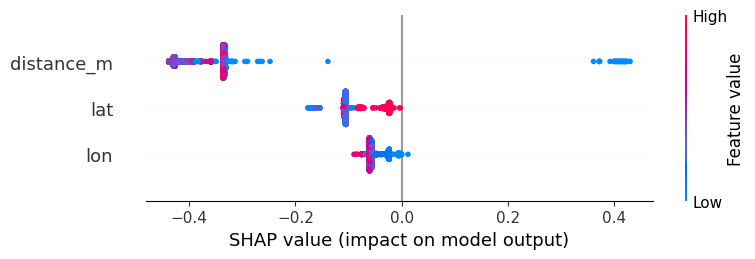

In [34]:
# Create a SHAP explainer for a tree-based model (e.g. Random Forest, XGBoost)
explainer = shap.TreeExplainer(rf_clf)

# Compute SHAP values for the validation set
shap_values = explainer.shap_values(X_val)

if isinstance(shap_values, list):
    # Older versions of SHAP return a list of arrays (one per class)
    shap_values_class = shap_values[1]
else:
    # Newer SHAP versions return a 3D array: (n_samples, n_features, n_classes)
    shap_values_class = shap_values[:, :, 1]

# Plot a summary of SHAP values to show feature importance and direction
shap.summary_plot(shap_values_class, X_val)


### XGBOOST

In [ ]:
# Define parameter grid for XGBoost
param_dist = {
    'n_estimators': randint(100, 400),         # Number of boosting rounds (trees)
    'max_depth': randint(5, 20),               # Maximum depth of each tree
    'learning_rate': uniform(0.01, 0.3),       # Step size shrinkage (smaller = slower but more stable)
    'subsample': uniform(0.6, 0.4),            # Fraction of training samples used per tree
    'colsample_bytree': uniform(0.6, 0.4),     # Fraction of features used per tree
    'scale_pos_weight': [1, 2, 5],             # Balances positive and negative classes (for imbalance)
    'gamma': uniform(0, 5),                    # Minimum loss reduction to make a split (regularization)
}

# Randomized hyperparameter search on training data
search = RandomizedSearchCV(
    XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1_weighted',                     # Evaluation metric for imbalanced classes
    cv=5,                                      # 5-fold cross-validation
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Fit the model
search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': <scipy.stats....x7ffabcc20440>, 'gamma': <scipy.stats....x7ffabc9c3050>, 'learning_rate': <scipy.stats....x7ffabca2d640>, 'max_depth': <scipy.stats....x7ffabca2e0c0>, ...}"
,n_iter,100
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [41]:
# Get best parameters and train final model
best_params = search.best_params_
xgb_clf = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

/home/rluyck/git/gps-stop-detection/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:02:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,np.float64(0.6699819708383744)
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [42]:
# Evaluate on validation set
print("Validation performance:")
print(classification_report(y_val, xgb_clf.predict(X_val)))

# Evaluate on test set
print("Test performance:")
print(classification_report(y_test, xgb_clf.predict(X_test)))

Validation performance:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      1804
        True       0.52      1.00      0.68        17

    accuracy                           0.99      1821
   macro avg       0.76      1.00      0.84      1821
weighted avg       1.00      0.99      0.99      1821

Test performance:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      1762
        True       0.72      1.00      0.84        23

    accuracy                           0.99      1785
   macro avg       0.86      1.00      0.92      1785
weighted avg       1.00      0.99      1.00      1785



In [ ]:
# Save model
model_path = "../models/stop_model_xgb.pkl"
joblib.dump(xgb_clf, model_path)

['../models/stop_model_xgb.pkl']

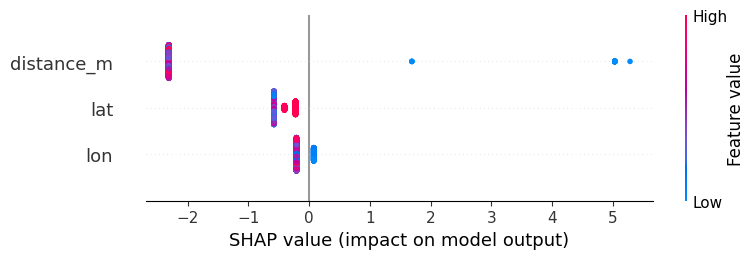

In [ ]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)
